In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2020-01-05 14:56:45.132041
thunder  Sun Jan  5 14:56:45 2020
[0] GeForce GTX 1080 Ti | 67'C,  95 % | 10936 / 11178 MB | david(10926M)
[1] GeForce GTX 1080 Ti | 73'C, 100 % | 10936 / 11178 MB | david(10926M)
[2] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 55'C,  29 % | 10895 / 11178 MB | anthoula(10885M)
[6] GeForce GTX 1080 Ti | 59'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[7] GeForce GTX 1080 Ti | 58'C,  44 % | 10895 / 11178 MB | anthoula(10885M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Sun Jan  5 14:56:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 51%   67C    P2   242W / 250W |  10936MiB / 11178MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 57%   74C    P2   251W / 250W |  10936Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "2"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
import tensorflow.python.keras.backend as K


In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# Setting class weight for retraining:

# compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
# n_NG , n_G

## Define Model and Metrics

In [14]:
reg_value=0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, 
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, 
                                featurewise_center=True, featurewise_std_normalization=True,
                                rescale= 1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    shuffle=False,
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model
# which_model = resnet50_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_F1', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 60s 1s/step - loss: 0.7205 - Accuracy: 0.5519 - Precision: 0.5622 - Recall: 0.5431 - F1: 0.5448 - AUC: 0.5841 - val_loss: 1.4497 - val_Accuracy: 0.0375 - val_Precision: 0.0345 - val_Recall: 0.7000 - val_F1: 0.0651 - val_AUC: 0.5612
Epoch 2/200
50/50 [==============================] - 53s 1s/step - loss: 0.6632 - Accuracy: 0.6206 - Precision: 0.6234 - Recall: 0.6487 - F1: 0.6282 - AUC: 0.6675 - val_loss: 1.8619 - val_Accuracy: 0.0094 - val_Precision: 0.0032 - val_Recall: 0.1000 - val_F1: 0.0062 - val_AUC: 0.7069
Epoch 3/200
50/50 [==============================] - 49s 978ms/step - loss: 0.6548 - Accuracy: 0.6369 - Precision: 0.6432 - Recall: 0.6393 - F1: 0.6349 - AUC: 0.6813 - val_loss: 3.3471 - val_Accuracy: 0.0219 - val_Precision: 0.0219 - val_Recall: 0.5000 - val_F1: 0.0414 - val_AUC: 0.4678
Epoch 4/200
50/50 [==============================] - 45s 906ms/step - loss: 0.6512 - Accuracy: 0.6313 - Precision: 0.6352 - Recall: 0.6684 - F1: 0.6426 - 

Epoch 29/200
50/50 [==============================] - 30s 607ms/step - loss: 0.5643 - Accuracy: 0.6944 - Precision: 0.6795 - Recall: 0.7213 - F1: 0.6939 - AUC: 0.7758 - val_loss: 0.8433 - val_Accuracy: 0.2344 - val_Precision: 0.0151 - val_Recall: 0.3000 - val_F1: 0.0287 - val_AUC: 0.4911
Epoch 30/200
50/50 [==============================] - 30s 603ms/step - loss: 0.5600 - Accuracy: 0.7044 - Precision: 0.7082 - Recall: 0.7159 - F1: 0.7052 - AUC: 0.7822 - val_loss: 0.8317 - val_Accuracy: 0.2375 - val_Precision: 0.0188 - val_Recall: 0.3000 - val_F1: 0.0353 - val_AUC: 0.6223
Epoch 31/200
50/50 [==============================] - 30s 609ms/step - loss: 0.5761 - Accuracy: 0.6975 - Precision: 0.7299 - Recall: 0.7096 - F1: 0.7133 - AUC: 0.7659 - val_loss: 0.8295 - val_Accuracy: 0.2875 - val_Precision: 0.0261 - val_Recall: 0.6000 - val_F1: 0.0500 - val_AUC: 0.6752
Epoch 32/200
50/50 [==============================] - 30s 606ms/step - loss: 0.5468 - Accuracy: 0.7269 - Precision: 0.7110 - Recall: 

50/50 [==============================] - 30s 592ms/step - loss: 0.5833 - Accuracy: 0.6731 - Precision: 0.6618 - Recall: 0.7024 - F1: 0.6736 - AUC: 0.7564 - val_loss: 0.7643 - val_Accuracy: 0.4187 - val_Precision: 0.0146 - val_Recall: 0.2000 - val_F1: 0.0272 - val_AUC: 0.7417
Epoch 58/200
50/50 [==============================] - 30s 592ms/step - loss: 0.5695 - Accuracy: 0.7113 - Precision: 0.7096 - Recall: 0.7302 - F1: 0.7144 - AUC: 0.7742 - val_loss: 0.8011 - val_Accuracy: 0.3375 - val_Precision: 0.0325 - val_Recall: 0.4500 - val_F1: 0.0602 - val_AUC: 0.4795
Epoch 59/200
50/50 [==============================] - 30s 592ms/step - loss: 0.5608 - Accuracy: 0.7044 - Precision: 0.6877 - Recall: 0.7433 - F1: 0.7081 - AUC: 0.7823 - val_loss: 0.8170 - val_Accuracy: 0.2969 - val_Precision: 0.0308 - val_Recall: 0.6000 - val_F1: 0.0583 - val_AUC: 0.7029
Epoch 60/200
50/50 [==============================] - 29s 585ms/step - loss: 0.5823 - Accuracy: 0.7006 - Precision: 0.6682 - Recall: 0.7486 - F1: 

50/50 [==============================] - 29s 574ms/step - loss: 0.5598 - Accuracy: 0.7106 - Precision: 0.7178 - Recall: 0.7254 - F1: 0.7123 - AUC: 0.7817 - val_loss: 0.8219 - val_Accuracy: 0.3031 - val_Precision: 0.0352 - val_Recall: 0.4000 - val_F1: 0.0639 - val_AUC: 0.5265
Epoch 86/200
50/50 [==============================] - 29s 571ms/step - loss: 0.5722 - Accuracy: 0.6925 - Precision: 0.6911 - Recall: 0.7243 - F1: 0.6984 - AUC: 0.7679 - val_loss: 0.8063 - val_Accuracy: 0.2781 - val_Precision: 0.0122 - val_Recall: 0.1667 - val_F1: 0.0223 - val_AUC: 0.2309
Epoch 87/200
50/50 [==============================] - 28s 568ms/step - loss: 0.5554 - Accuracy: 0.7262 - Precision: 0.7290 - Recall: 0.7480 - F1: 0.7341 - AUC: 0.7900 - val_loss: 0.7629 - val_Accuracy: 0.3438 - val_Precision: 0.0391 - val_Recall: 0.5833 - val_F1: 0.0727 - val_AUC: 0.5829
Epoch 88/200
50/50 [==============================] - 28s 568ms/step - loss: 0.5628 - Accuracy: 0.7075 - Precision: 0.6985 - Recall: 0.7387 - F1: 

50/50 [==============================] - 29s 578ms/step - loss: 0.5542 - Accuracy: 0.7188 - Precision: 0.7203 - Recall: 0.7304 - F1: 0.7201 - AUC: 0.7937 - val_loss: 0.8715 - val_Accuracy: 0.2219 - val_Precision: 0.0158 - val_Recall: 0.3500 - val_F1: 0.0302 - val_AUC: 0.4811
Epoch 114/200
50/50 [==============================] - 30s 590ms/step - loss: 0.5711 - Accuracy: 0.6913 - Precision: 0.6699 - Recall: 0.7290 - F1: 0.6916 - AUC: 0.7715 - val_loss: 0.9122 - val_Accuracy: 0.2875 - val_Precision: 0.0080 - val_Recall: 0.2000 - val_F1: 0.0154 - val_AUC: 0.6399
Epoch 115/200
50/50 [==============================] - 28s 567ms/step - loss: 0.5670 - Accuracy: 0.6956 - Precision: 0.7036 - Recall: 0.7239 - F1: 0.7049 - AUC: 0.7703 - val_loss: 0.8790 - val_Accuracy: 0.2625 - val_Precision: 0.0331 - val_Recall: 0.5000 - val_F1: 0.0618 - val_AUC: 0.4802
Epoch 116/200
50/50 [==============================] - 29s 582ms/step - loss: 0.5568 - Accuracy: 0.7156 - Precision: 0.7094 - Recall: 0.7270 - F

50/50 [==============================] - 21s 414ms/step - loss: 0.5493 - Accuracy: 0.7188 - Precision: 0.7132 - Recall: 0.7340 - F1: 0.7176 - AUC: 0.7932 - val_loss: 0.9304 - val_Accuracy: 0.2281 - val_Precision: 0.0166 - val_Recall: 0.4000 - val_F1: 0.0319 - val_AUC: 0.4889
Epoch 142/200
50/50 [==============================] - 21s 418ms/step - loss: 0.5369 - Accuracy: 0.7362 - Precision: 0.7155 - Recall: 0.7666 - F1: 0.7358 - AUC: 0.8096 - val_loss: 0.9280 - val_Accuracy: 0.1531 - val_Precision: 0.0142 - val_Recall: 0.2500 - val_F1: 0.0267 - val_AUC: 0.5196
Epoch 143/200
50/50 [==============================] - 20s 403ms/step - loss: 0.5730 - Accuracy: 0.6931 - Precision: 0.6998 - Recall: 0.7099 - F1: 0.6977 - AUC: 0.7673 - val_loss: 1.0054 - val_Accuracy: 0.2188 - val_Precision: 0.0163 - val_Recall: 0.3500 - val_F1: 0.0309 - val_AUC: 0.5135
Epoch 144/200
50/50 [==============================] - 21s 416ms/step - loss: 0.5534 - Accuracy: 0.7200 - Precision: 0.7219 - Recall: 0.7310 - F

50/50 [==============================] - 21s 410ms/step - loss: 0.5384 - Accuracy: 0.7156 - Precision: 0.6789 - Recall: 0.7549 - F1: 0.7074 - AUC: 0.8079 - val_loss: 0.9369 - val_Accuracy: 0.3125 - val_Precision: 0.0074 - val_Recall: 0.1500 - val_F1: 0.0140 - val_AUC: 0.3347
Epoch 170/200
50/50 [==============================] - 21s 415ms/step - loss: 0.5330 - Accuracy: 0.7319 - Precision: 0.7477 - Recall: 0.7282 - F1: 0.7300 - AUC: 0.8146 - val_loss: 0.8175 - val_Accuracy: 0.3094 - val_Precision: 0.0256 - val_Recall: 0.3500 - val_F1: 0.0468 - val_AUC: 0.4759
Epoch 171/200
50/50 [==============================] - 21s 426ms/step - loss: 0.5608 - Accuracy: 0.7094 - Precision: 0.7075 - Recall: 0.7305 - F1: 0.7134 - AUC: 0.7842 - val_loss: 0.7971 - val_Accuracy: 0.3219 - val_Precision: 0.0416 - val_Recall: 0.6500 - val_F1: 0.0773 - val_AUC: 0.6721
Epoch 172/200
50/50 [==============================] - 20s 404ms/step - loss: 0.5380 - Accuracy: 0.7175 - Precision: 0.7087 - Recall: 0.7469 - F

50/50 [==============================] - 21s 414ms/step - loss: 0.5406 - Accuracy: 0.7356 - Precision: 0.7312 - Recall: 0.7511 - F1: 0.7364 - AUC: 0.8054 - val_loss: 0.8648 - val_Accuracy: 0.3250 - val_Precision: 0.0152 - val_Recall: 0.3000 - val_F1: 0.0289 - val_AUC: 0.5111
Epoch 198/200
50/50 [==============================] - 19s 375ms/step - loss: 0.5562 - Accuracy: 0.7081 - Precision: 0.7054 - Recall: 0.7338 - F1: 0.7124 - AUC: 0.7857 - val_loss: 0.8168 - val_Accuracy: 0.3406 - val_Precision: 0.0318 - val_Recall: 0.5167 - val_F1: 0.0590 - val_AUC: 0.4573
Epoch 199/200
50/50 [==============================] - 18s 361ms/step - loss: 0.5717 - Accuracy: 0.6900 - Precision: 0.6875 - Recall: 0.7059 - F1: 0.6906 - AUC: 0.7694 - val_loss: 0.8102 - val_Accuracy: 0.3906 - val_Precision: 0.0661 - val_Recall: 0.7417 - val_F1: 0.1183 - val_AUC: 0.6436
Epoch 200/200
50/50 [==============================] - 19s 385ms/step - loss: 0.5611 - Accuracy: 0.7081 - Precision: 0.7217 - Recall: 0.7202 - F

In [21]:
print("Time taken:",end-start)

Time taken: 5417.0161464214325


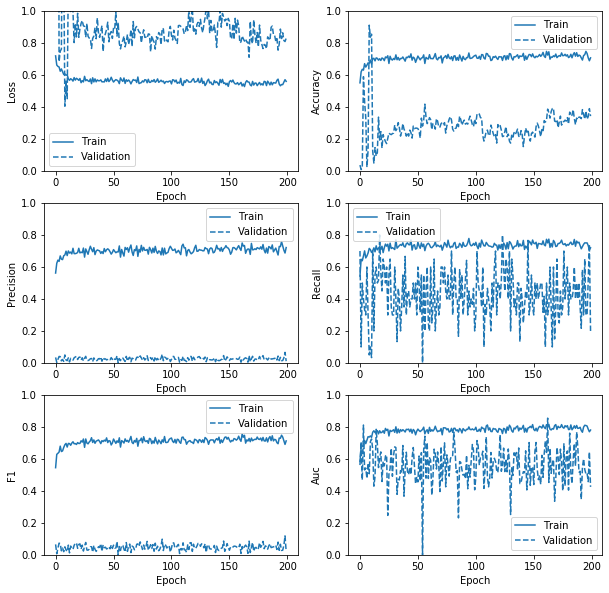

In [45]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 20s 400ms/step - loss: 0.6975 - Accuracy: 0.5738 - Precision: 0.1506 - Recall: 0.7777 - F1: 0.2418 - AUC: 0.7948 - val_loss: 1.0516 - val_Accuracy: 0.2188 - val_Precision: 0.0349 - val_Recall: 0.6000 - val_F1: 0.0652 - val_AUC: 0.6421
Epoch 2/200
50/50 [==============================] - 18s 366ms/step - loss: 0.6588 - Accuracy: 0.6175 - Precision: 0.1557 - Recall: 0.6670 - F1: 0.2426 - AUC: 0.7760 - val_loss: 0.9797 - val_Accuracy: 0.1562 - val_Precision: 0.0038 - val_Recall: 0.1000 - val_F1: 0.0074 - val_AUC: 0.3762
Epoch 3/200
50/50 [==============================] - 22s 445ms/step - loss: 0.6315 - Accuracy: 0.6319 - Precision: 0.1630 - Recall: 0.6853 - F1: 0.2554 - AUC: 0.7584 - val_loss: 0.9523 - val_Accuracy: 0.1750 - val_Precision: 0.0194 - val_Recall: 0.3667 - val_F1: 0.0363 - val_AUC: 0.5205
Epoch 4/200
50/50 [==============================] - 17s 347ms/step - loss: 0.6054 - Accuracy: 0.6612 - Precision: 0.1877 - Recall: 0.73

50/50 [==============================] - 15s 307ms/step - loss: 0.3599 - Accuracy: 0.8850 - Precision: 0.3567 - Recall: 0.2563 - F1: 0.2801 - AUC: 0.7715 - val_loss: 0.7093 - val_Accuracy: 0.4156 - val_Precision: 0.0154 - val_Recall: 0.2500 - val_F1: 0.0290 - val_AUC: 0.4590
Epoch 30/200
50/50 [==============================] - 15s 307ms/step - loss: 0.3532 - Accuracy: 0.8831 - Precision: 0.2920 - Recall: 0.2771 - F1: 0.2569 - AUC: 0.7798 - val_loss: 0.6920 - val_Accuracy: 0.4500 - val_Precision: 0.0185 - val_Recall: 0.2000 - val_F1: 0.0339 - val_AUC: 0.5833
Epoch 31/200
50/50 [==============================] - 16s 315ms/step - loss: 0.3426 - Accuracy: 0.8944 - Precision: 0.2843 - Recall: 0.2829 - F1: 0.2563 - AUC: 0.7934 - val_loss: 0.6893 - val_Accuracy: 0.5000 - val_Precision: 0.0323 - val_Recall: 0.5000 - val_F1: 0.0606 - val_AUC: 0.6563
Epoch 32/200
50/50 [==============================] - 17s 347ms/step - loss: 0.3399 - Accuracy: 0.8881 - Precision: 0.2897 - Recall: 0.2346 - F1: 

50/50 [==============================] - 17s 341ms/step - loss: 0.2841 - Accuracy: 0.9050 - Precision: 0.2100 - Recall: 0.0913 - F1: 0.1213 - AUC: 0.7998 - val_loss: 0.5108 - val_Accuracy: 0.8562 - val_Precision: 0.0310 - val_Recall: 0.1500 - val_F1: 0.0508 - val_AUC: 0.7195
Epoch 58/200
50/50 [==============================] - 15s 309ms/step - loss: 0.2770 - Accuracy: 0.9062 - Precision: 0.1800 - Recall: 0.0835 - F1: 0.1027 - AUC: 0.8068 - val_loss: 0.5215 - val_Accuracy: 0.8094 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4147
Epoch 59/200
50/50 [==============================] - 15s 296ms/step - loss: 0.2792 - Accuracy: 0.9075 - Precision: 0.1967 - Recall: 0.0973 - F1: 0.1214 - AUC: 0.8018 - val_loss: 0.5251 - val_Accuracy: 0.8313 - val_Precision: 0.0400 - val_Recall: 0.1500 - val_F1: 0.0619 - val_AUC: 0.6086
Epoch 60/200
50/50 [==============================] - 16s 318ms/step - loss: 0.2877 - Accuracy: 0.9050 - Precision: 0.2333 - Recall: 0

Epoch 85/200
50/50 [==============================] - 19s 382ms/step - loss: 0.2496 - Accuracy: 0.9100 - Precision: 0.0600 - Recall: 0.0217 - F1: 0.0313 - AUC: 0.8290 - val_loss: 0.4205 - val_Accuracy: 0.9250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5352
Epoch 86/200
50/50 [==============================] - 20s 400ms/step - loss: 0.2654 - Accuracy: 0.9075 - Precision: 0.0400 - Recall: 0.0117 - F1: 0.0180 - AUC: 0.7859 - val_loss: 0.4074 - val_Accuracy: 0.9344 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.2227
Epoch 87/200
50/50 [==============================] - 19s 386ms/step - loss: 0.2753 - Accuracy: 0.9025 - Precision: 0.1000 - Recall: 0.0282 - F1: 0.0424 - AUC: 0.7924 - val_loss: 0.3399 - val_Accuracy: 0.9344 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5739
Epoch 88/200
50/50 [==============================] - 20s 392ms/step - loss: 0.2522 - Accuracy: 0

50/50 [==============================] - 16s 310ms/step - loss: 0.2516 - Accuracy: 0.9156 - Precision: 0.0600 - Recall: 0.0157 - F1: 0.0247 - AUC: 0.7923 - val_loss: 0.3942 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3953
Epoch 113/200
50/50 [==============================] - 16s 321ms/step - loss: 0.2682 - Accuracy: 0.9069 - Precision: 0.1200 - Recall: 0.0440 - F1: 0.0584 - AUC: 0.7894 - val_loss: 0.3345 - val_Accuracy: 0.9500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4676
Epoch 114/200
50/50 [==============================] - 18s 365ms/step - loss: 0.2669 - Accuracy: 0.9019 - Precision: 0.0400 - Recall: 0.0167 - F1: 0.0233 - AUC: 0.7978 - val_loss: 0.3740 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5975
Epoch 115/200
50/50 [==============================] - 18s 362ms/step - loss: 0.2528 - Accuracy: 0.9137 - Pr

50/50 [==============================] - 17s 330ms/step - loss: 0.2621 - Accuracy: 0.9019 - Precision: 0.0600 - Recall: 0.0173 - F1: 0.0267 - AUC: 0.8253 - val_loss: 0.3138 - val_Accuracy: 0.9812 - val_Precision: 0.1000 - val_Recall: 0.1000 - val_F1: 0.1000 - val_AUC: 0.4324
Epoch 140/200
50/50 [==============================] - 15s 302ms/step - loss: 0.2691 - Accuracy: 0.9025 - Precision: 0.0200 - Recall: 0.0040 - F1: 0.0067 - AUC: 0.7964 - val_loss: 0.2978 - val_Accuracy: 0.9469 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4559
Epoch 141/200
50/50 [==============================] - 15s 308ms/step - loss: 0.2419 - Accuracy: 0.9156 - Precision: 0.0800 - Recall: 0.0550 - F1: 0.0613 - AUC: 0.8226 - val_loss: 0.3602 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5328
Epoch 142/200
50/50 [==============================] - 16s 314ms/step - loss: 0.2498 - Accuracy: 0.9100 - Precision: 0.0

50/50 [==============================] - 18s 365ms/step - loss: 0.2735 - Accuracy: 0.9038 - Precision: 0.1200 - Recall: 0.0390 - F1: 0.0573 - AUC: 0.7789 - val_loss: 0.2715 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5038
Epoch 167/200
50/50 [==============================] - 18s 359ms/step - loss: 0.2555 - Accuracy: 0.9056 - Precision: 0.1400 - Recall: 0.0388 - F1: 0.0596 - AUC: 0.8224 - val_loss: 0.2686 - val_Accuracy: 0.9906 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6187
Epoch 168/200
50/50 [==============================] - 18s 355ms/step - loss: 0.2661 - Accuracy: 0.9038 - Precision: 0.0600 - Recall: 0.0119 - F1: 0.0197 - AUC: 0.7953 - val_loss: 0.2792 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6128
Epoch 169/200
50/50 [==============================] - 18s 355ms/step - loss: 0.2437 - Accuracy: 0.9169 - Pr

50/50 [==============================] - 16s 310ms/step - loss: 0.2428 - Accuracy: 0.9119 - Precision: 0.1200 - Recall: 0.0333 - F1: 0.0508 - AUC: 0.8302 - val_loss: 0.2758 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5531
Epoch 194/200
50/50 [==============================] - 16s 314ms/step - loss: 0.2499 - Accuracy: 0.9156 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7643 - val_loss: 0.2443 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6057
Epoch 195/200
50/50 [==============================] - 16s 316ms/step - loss: 0.2545 - Accuracy: 0.9087 - Precision: 0.0700 - Recall: 0.0300 - F1: 0.0413 - AUC: 0.8045 - val_loss: 0.3867 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5429
Epoch 196/200
50/50 [==============================] - 15s 309ms/step - loss: 0.2800 - Accuracy:

In [24]:
print("Time taken:",end-start)

Time taken: 3452.770495891571


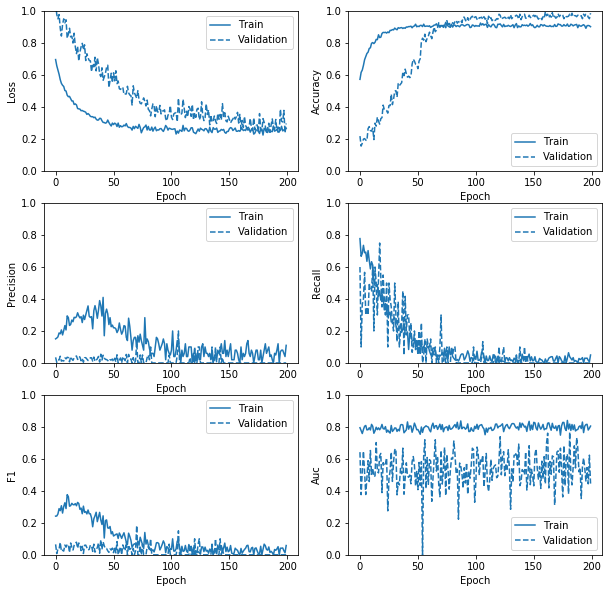

In [46]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
# start = time.time()
# up3_history = model.fit_generator(up3_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [0.5, 1],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [27]:
# print("Time taken:",end-start)

In [28]:
# plt.figure(figsize=(10,10))
# plot_metrics(up3_history)

### Train with Imbalanced original train data (1:40)

In [29]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.5, 2],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [47]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 24s 238ms/step


In [48]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.274 :   0.340
Accuracy : 0.978 :   0.974
Precision : 0.010 :   0.010
Recall : 0.010 :   0.005
F1 : 0.010 :   0.007
AUC : 0.539 :   0.537


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [34]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(972.6558072566986, 162.6217200756073)

In [35]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [36]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [37]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

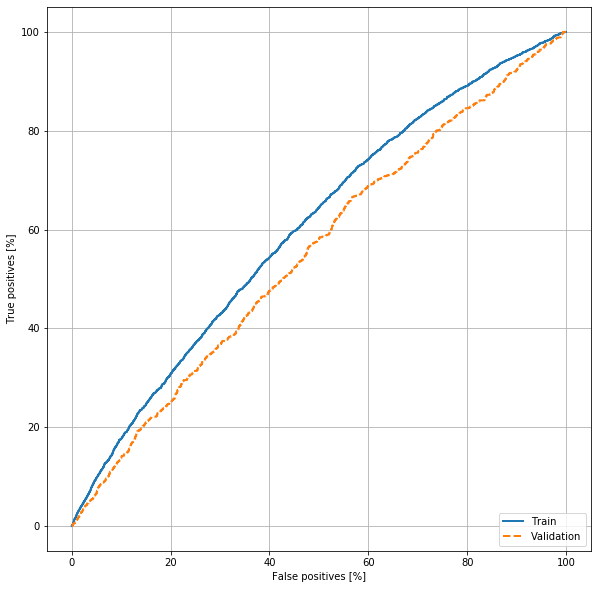

In [38]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 99284 
FP: 171 
FN: 2373 
TP: 6
Healthy Patients - correctly identified (True Negatives):  99284 0.9982806294303956
Healthy Patients - predicted to have glaucoma (False Positives):  171 0.0017193705696043437
Glaucoma Patients - predicted healthy (False Negatives):  2373 0.9974779319041615
Glaucoma Patients - correctly identified (True Positives):  6 0.0025220680958385876

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


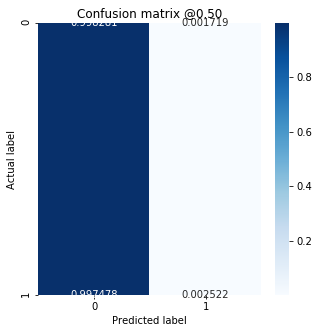

In [39]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33019 
FP: 115 
FN: 805 
TP: 4
Healthy Patients - correctly identified (True Negatives):  33019 0.9965292448844087
Healthy Patients - predicted to have glaucoma (False Positives):  115 0.0034707551155912356
Glaucoma Patients - predicted healthy (False Negatives):  805 0.9950556242274413
Glaucoma Patients - correctly identified (True Positives):  4 0.004944375772558714

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


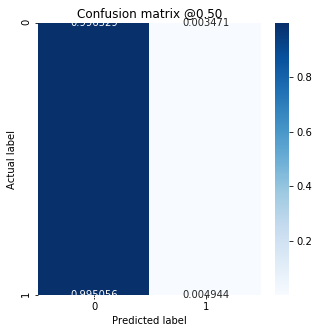

In [40]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [41]:
datetime.datetime.now().strftime("%d%b%Y %H:%M")

'05Jan2020 17:45'

In [42]:
# history = up2_history
# tag_value = "trained twice bal and 1:10 with 78 tr layers"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [43]:
# client = MlflowClient()
# run = client.create_run('16')
# client.set_tag(run.info.run_id, "tag_key", tag_value)